In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer

# State level analysis

In [2]:
path = r"C:\Users\Sarth\OneDrive\Merger Analysis of Duke Energy and Progress Energy\Git testing\State Level and IOU Data.xlsx"

state_sheet = 'Main'

state = pd.read_excel(path, sheet_name = state_sheet, header = 0)
state_true = pd.read_excel(path, sheet_name = state_sheet, header = 0)

## Set Up and Cleaning

### Imputation for resources

In [5]:
# Defining the columns of interest

national_columns = ['Coal_Cost_US', 'Fuel_Cost_US', 'Gas_Cost_US', 'Nuclear_Cost_US']
state_columns = ['Cost_Coal_MBTU', 'Cost_FuelOil_MBTU', 'Cost_NaturalGas_MBTU', 'Cost_Nuclear_MBTU']

In [6]:
# Creating new columns to fill up data and equating to existing values

imputed_national_columns = [f"{col}_Imputed" for col in national_columns]
state[imputed_national_columns] = state[national_columns]

In [7]:
# Imputing values using 'mean' strategy and updating associated values

imputer = SimpleImputer(strategy='mean')
state[national_columns] = imputer.fit_transform(state[national_columns])

In [8]:
# Double checking using linear regression and updating those values that are either or nans

    # Dividing the data into known and missing values
    # If function to check for missing values and fill, if missing
    # Predict the missing values
    

def impute_state_cost(state_column, national_column):
    
    known_data = state[[state_column, national_column]].dropna()
    missing_data = state[state[state_column].isnull()]

    model = LinearRegression()
    model.fit(known_data[national_column].values.reshape(-1, 1), known_data[state_column])

    predicted_values = model.predict(missing_data[national_column].values.reshape(-1, 1))
    state.loc[state[state_column].isnull(), state_column] = predicted_values

In [9]:
for state_col, national_col in zip(state_columns, national_columns):
    impute_state_cost(state_col, national_col)

In [10]:
state_copy = state.copy()

#### Ensuring that imputations are accurate

In [13]:
variables = ['Coal_Cost_US_Imputed', 'Coal_Cost_US', 'Fuel_Cost_US_Imputed', 'Fuel_Cost_US',
             'Gas_Cost_US_Imputed', 'Gas_Cost_US', 'Nuclear_Cost_US_Imputed', 'Nuclear_Cost_US']

scaling_factors = {
    'Coal_Cost_US_Imputed': 1/4,
    'Coal_Cost_US': 1/4,
    'Fuel_Cost_US_Imputed': 5,
    'Fuel_Cost_US': 5,
    'Gas_Cost_US_Imputed': 3,
    'Gas_Cost_US': 3,
    'Nuclear_Cost_US_Imputed': 1/4,
    'Nuclear_Cost_US': 1/4
}


avg_df = state_copy.groupby(['Year'])[variables].mean().reset_index()


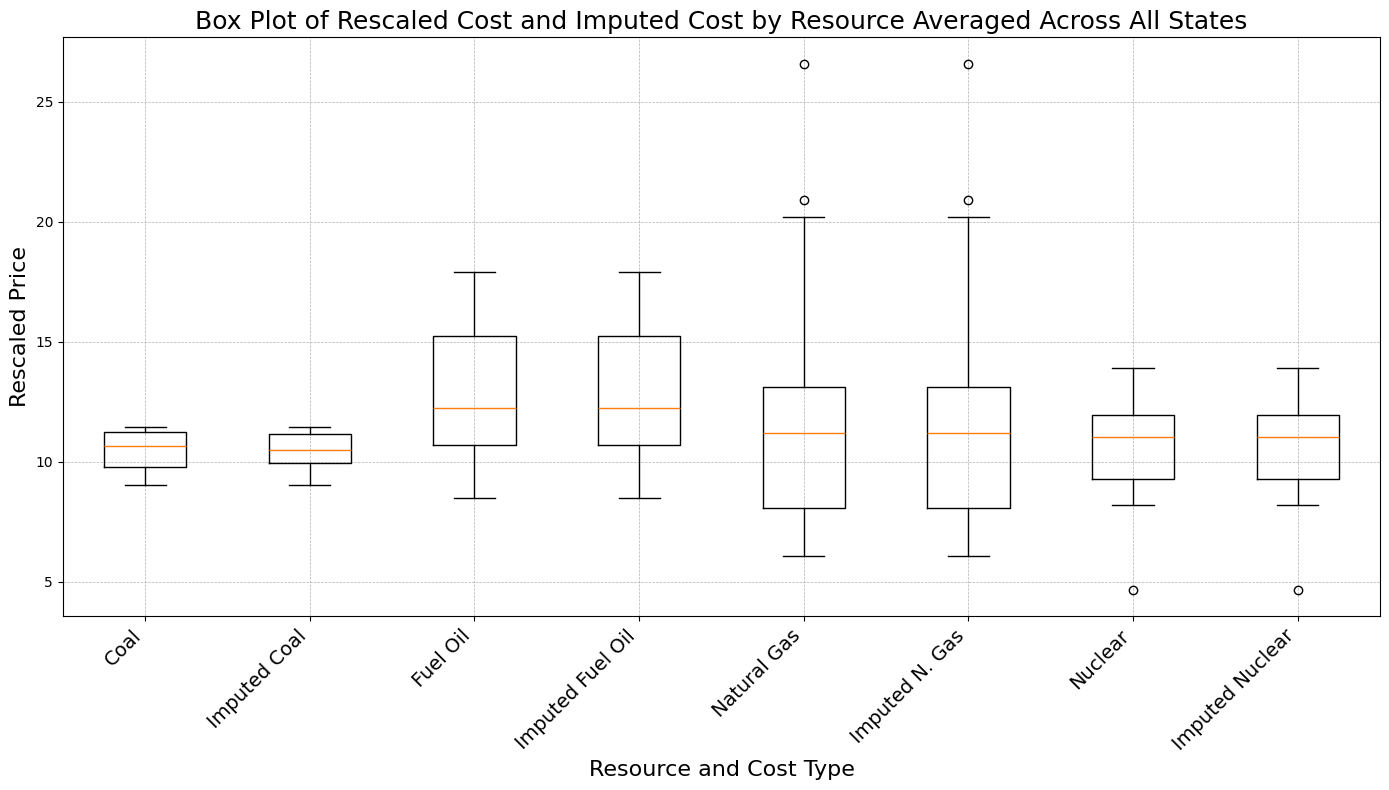

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

avg_df = state_copy.groupby(['Year'])[variables].mean().reset_index()

# Rescale the data
for var in variables:
    avg_df[var] *= scaling_factors[var]

# Prepare data for box plots, removing empty data points
data_to_plot = [avg_df[var].dropna() for var in variables]

fig, ax = plt.subplots(figsize=(14, 8))

ax.boxplot(data_to_plot)

x_labels = ['Coal', 'Imputed Coal', 'Fuel Oil', 'Imputed Fuel Oil',
            'Natural Gas', 'Imputed N. Gas', 'Nuclear', 'Imputed Nuclear']
ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=14)
ax.set_xlabel('Resource and Cost Type', fontsize=16)
ax.set_ylabel('Rescaled Price', fontsize=16)
ax.set_title('Box Plot of Rescaled Cost and Imputed Cost by Resource Averaged Across All States', fontsize=18)

ax.grid(True, linestyle='--', linewidth=0.5)
fig.patch.set_facecolor('white')

plt.tight_layout()

plt.show()

### Filtering for those that satisfy general requirements

In [15]:
# Identifying states and merger, iou and rto indicators
state_filters = state[['STATE','Any_merger?', 'IOU_Merger','Dummy_State_RTO']]

# Creating summary statistics by state to remove out of contention states
states_sum = state_filters.groupby('STATE').mean().reset_index()

In [16]:
# Creating df for those states without a merger, or in treatment states

no_merger = states_sum[((states_sum['IOU_Merger'] == 0) & (states_sum['Dummy_State_RTO'] == 0)) |
                       ((states_sum['STATE'] == 'NC') | (states_sum['STATE'] == 'SC'))]

states_val = list(no_merger['STATE'].unique())

# Filtering the df for only those states that fit above
state_filt = state[state['STATE'].isin(states_val)].reset_index(drop = 'True')

In [17]:
state_filt['PCI'] = state_filt['Real_GSP']/state_filt['Population']
state_filt['Cons_Res'] = state_filt['KWH_res']*state_filt['Cust_Res']
state_filt['Cons_Com'] = state_filt['KWH_com']*state_filt['Cust_com']
state_filt['Cons_Indus'] = state_filt['KWH_indus']*state_filt['Cust_indus']

state_filt_copy = state_filt.copy()

### Creating log variables for stata regression

In [18]:
import numpy as np
# creating necessary log transformations for use in regression using stata

columns_to_log = ['CPKWH_res','Cons_Res','Cons_Com','Cons_Indus','CPKWH_com','CPKWH_indus','Cust_Res',
                  'Cust_com','Cust_indus','KWH_res','KWH_com','KWH_indus','PCI']

for col in columns_to_log:
    cols = f"log_{col}"
    state_filt[cols] = np.log(state_filt[col])

### Identifying dummy variables for weather risk states

In [19]:
weather_risk_states = ['NC', 'SC', 'GA', 'AL', 'FL', 'TX', 'MS', 'LA', 'VA']

state_filt['shore_weather_risk'] = state_filt['STATE'].apply(
    lambda x: 1 if x in weather_risk_states else 0
)

In [20]:
## Creating dummy variables for treatment and post indicator

state_filt['treat_NC'] = (state_filt['STATE']=="NC").astype(float)
state_filt['treat_SC'] = (state_filt['STATE']=="SC").astype(float)
state_filt['post16'] = (state_filt['Year']>2015).astype(float)
state_filt['post16Xtreatment_NC'] = state_filt['treat_NC']*state_filt['post16']
state_filt['post16Xtreatment_SC'] = state_filt['treat_SC']*state_filt['post16']

In [21]:
state_filt['Usage_Coal_ShTonne'].isna().value_counts()

Usage_Coal_ShTonne
False    285
Name: count, dtype: int64

### Understanding total spend on each type of resource

In [22]:
state_filt['effect_cost_coal'] = state_filt['Usage_Coal_ShTonne'] * state_filt['Coal_Cost_US_Imputed']
state_filt['effect_cost_fuel'] = state_filt['Usage_FuelOil_Barrel'] * state_filt['Fuel_Cost_US_Imputed']
state_filt['effect_cost_ngas'] = state_filt['Usage_NaturalGas_Mcf'] * state_filt['Gas_Cost_US_Imputed']

### Understanding pre-treatment trends

In [23]:
state_filt['STATE'].unique() # identifying states for debugging

array(['GA', 'NC', 'CO', 'IN', 'TN', 'AZ', 'WI', 'LA', 'SC', 'AL', 'KY',
       'NV', 'MS', 'NM', 'HI', 'ND', 'AK', 'SD', 'MT'], dtype=object)

In [24]:
state_filt = state_filt.sort_values(by=['STATE', 'Year'])

In [25]:
state_filt_b16 = state_filt[state_filt['Year']<2016] # filtering for before 2016 for pre-treat

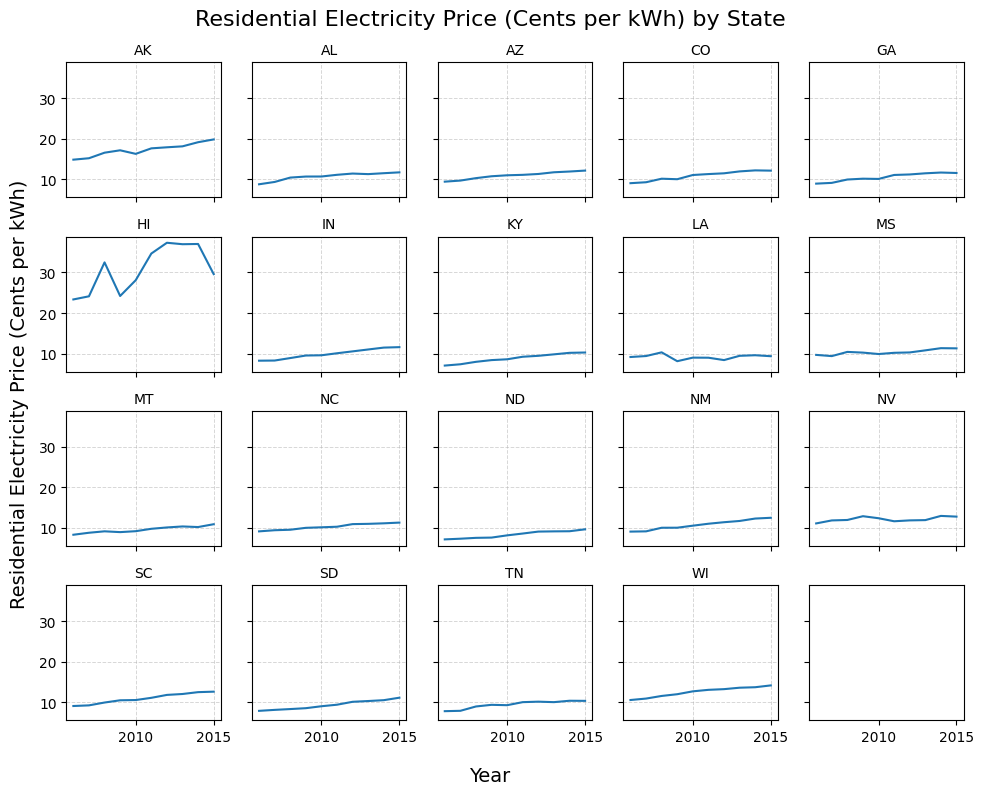

In [26]:
state_filt_b16_r = state_filt_b16[['Year', 'STATE', 'CPKWH_res']] # Pulling only year, state, res

unique_states = state_filt_b16_r['STATE'].unique() # collecting all unique states

fig, axes = plt.subplots(4, 5, figsize=(10, 8), sharex=True, sharey=True)

axes = axes.flatten()

for i, state in enumerate(unique_states):
    state_subset = state_filt_b16_r[state_filt_b16_r['STATE'] == state]
    axes[i].plot(state_subset['Year'], state_subset['CPKWH_res'], label=state, linewidth=1.5)
    axes[i].set_title(state, fontsize=10)
    axes[i].grid(alpha=0.5, linestyle='--', linewidth=0.7)

fig.suptitle('Residential Electricity Price (Cents per kWh) by State', fontsize=16)
fig.supxlabel('Year', fontsize=14)
fig.supylabel('Residential Electricity Price (Cents per kWh)', fontsize=14)

plt.tight_layout()

plt.show()


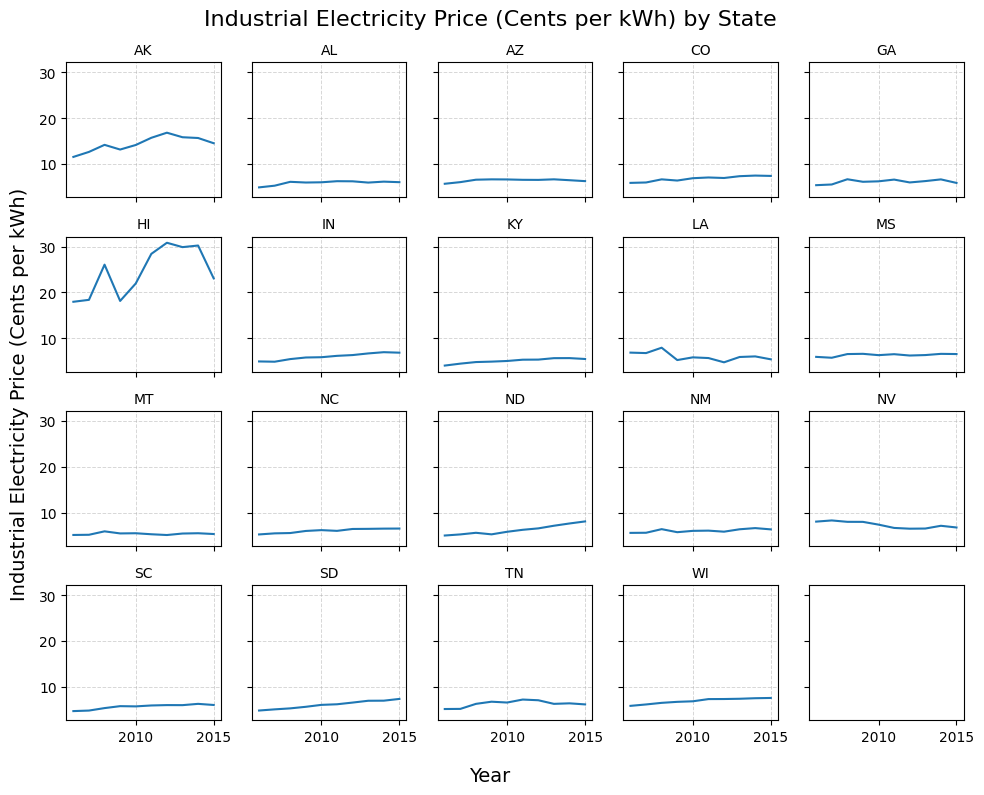

In [27]:
state_filt_b16_r = state_filt_b16[['Year', 'STATE', 'CPKWH_indus']] # Pulling only year, state, res

unique_states = state_filt_b16_r['STATE'].unique() # collecting all unique states

fig, axes = plt.subplots(4, 5, figsize=(10, 8), sharex=True, sharey=True)

axes = axes.flatten()


for i, state in enumerate(unique_states):
    state_subset = state_filt_b16_r[state_filt_b16_r['STATE'] == state]
    axes[i].plot(state_subset['Year'], state_subset['CPKWH_indus'], label=state, linewidth=1.5)
    axes[i].set_title(state, fontsize=10)
    axes[i].grid(alpha=0.5, linestyle='--', linewidth=0.7)

fig.suptitle('Industrial Electricity Price (Cents per kWh) by State', fontsize=16)
fig.supxlabel('Year', fontsize=14)
fig.supylabel('Industrial Electricity Price (Cents per kWh)', fontsize=14)

plt.tight_layout()

plt.show()


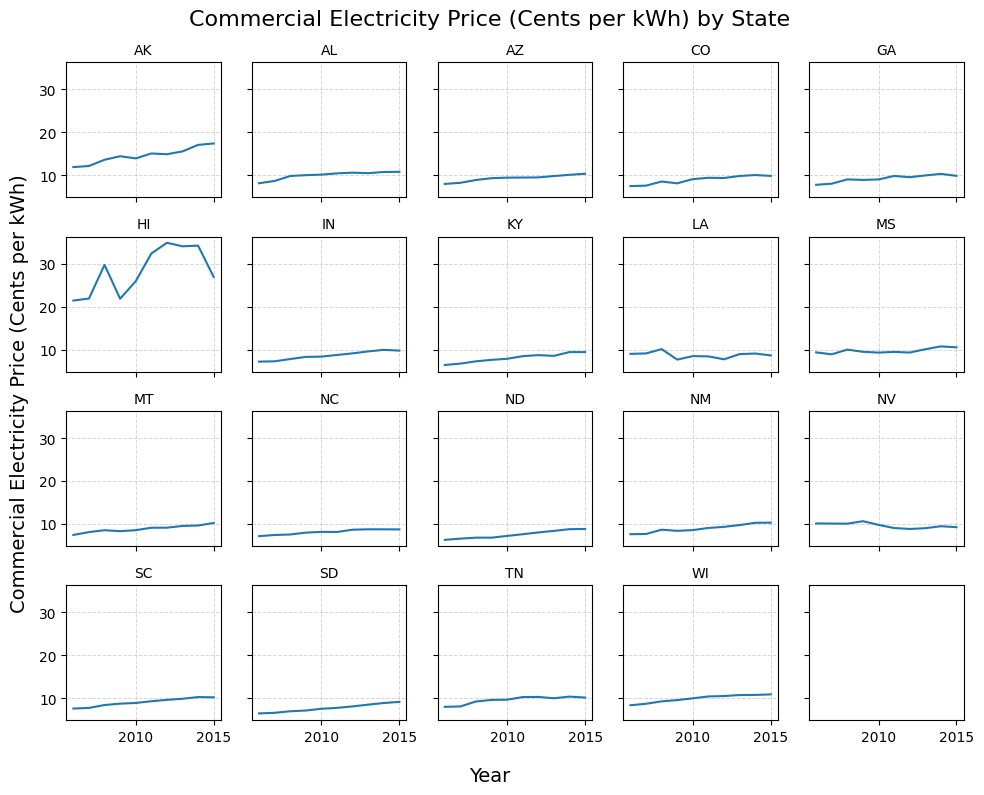

In [28]:
import matplotlib.pyplot as plt

state_filt_b16_r = state_filt_b16[['Year', 'STATE', 'CPKWH_com']] # Pulling only year, state, res

unique_states = state_filt_b16_r['STATE'].unique() # collecting all unique states

fig, axes = plt.subplots(4, 5, figsize=(10, 8), sharex=True, sharey=True)

axes = axes.flatten()


for i, state in enumerate(unique_states):
    state_subset = state_filt_b16_r[state_filt_b16_r['STATE'] == state]
    axes[i].plot(state_subset['Year'], state_subset['CPKWH_com'], label=state, linewidth=1.5)
    axes[i].set_title(state, fontsize=10)
    axes[i].grid(alpha=0.5, linestyle='--', linewidth=0.7)

fig.suptitle('Commercial Electricity Price (Cents per kWh) by State', fontsize=16)
fig.supxlabel('Year', fontsize=14)
fig.supylabel('Commercial Electricity Price (Cents per kWh)', fontsize=14)

plt.tight_layout()

plt.show()


In [29]:
# Based on above, we decide to drop HI, LA, NV as it violates parallel trends effect

state_filt = state_filt[~state_filt['STATE'].isin(['HI', 'LA', 'NV'])]

## Regression analysis

In [31]:
from linearmodels.panel import PanelOLS

dependent_vars = ['log_CPKWH_res', 'log_CPKWH_com', 'log_CPKWH_indus']

# Defining dictionary for residential, commercial, industrial for NC and SC
indep_vars_dict_NC = {
    'log_CPKWH_res': ['log_Cust_Res', 'log_KWH_res', 'post16Xtreatment_NC', 'post16', 'treat_NC', 
                      'log_PCI','shore_weather_risk'],
    'log_CPKWH_com': ['log_Cust_com', 'log_KWH_com', 'post16Xtreatment_NC', 'post16', 'treat_NC', 
                      'log_PCI', 'shore_weather_risk'],
    'log_CPKWH_indus': ['log_Cust_indus', 'log_KWH_indus', 'post16Xtreatment_NC', 'post16', 'treat_NC', 
                        'log_PCI', 'shore_weather_risk']
}

indep_vars_dict_SC = {
    'log_CPKWH_res': ['log_Cust_Res', 'log_KWH_res', 'post16Xtreatment_SC', 'post16', 'treat_SC', 
                      'log_PCI', 'shore_weather_risk'],
    'log_CPKWH_com': ['log_Cust_com', 'log_KWH_com', 'post16Xtreatment_SC', 'post16', 'treat_SC', 
                      'log_PCI', 'shore_weather_risk'],
    'log_CPKWH_indus': ['log_Cust_indus', 'log_KWH_indus', 'post16Xtreatment_SC', 'post16', 'treat_SC', 
                        'log_PCI', 'shore_weather_risk']
}

In [32]:
# Creating dataset for regression for NC and SC respectively and defn the index
NC_reg = state_filt[state_filt['STATE']!="SC"]
NC_reg.set_index(['STATE', 'Year'], inplace=True)
NC_results={}
SC_reg = state_filt[state_filt['STATE']!="NC"]
SC_reg.set_index(['STATE', 'Year'], inplace=True)
SC_results={}

In [33]:
for dep_var, indep_vars in indep_vars_dict_NC.items():
    exog = NC_reg[indep_vars]
    model = PanelOLS(NC_reg[dep_var], exog, entity_effects=False,time_effects=False)
    NC_results[f"{dep_var}_NC"] = model.fit(cov_type='clustered', cluster_entity=True)

In [34]:
NC_results

{'log_CPKWH_res_NC':                           PanelOLS Estimation Summary                           
 Dep. Variable:          log_CPKWH_res   R-squared:                        0.9907
 Estimator:                   PanelOLS   R-squared (Between):              0.9919
 No. Observations:                 225   R-squared (Within):               0.4422
 Date:                Fri, Jan 03 2025   R-squared (Overall):              0.9907
 Time:                        23:26:54   Log-likelihood                    9.2649
 Cov. Estimator:             Clustered                                           
                                         F-statistic:                      3307.0
 Entities:                          15   P-value                           0.0000
 Avg Obs:                       15.000   Distribution:                   F(7,218)
 Min Obs:                       15.000                                           
 Max Obs:                       15.000   F-statistic (robust):         -1.679e

In [35]:
for dep_var, indep_vars in indep_vars_dict_SC.items():
    exog = SC_reg[indep_vars]
    model = PanelOLS(SC_reg[dep_var], exog, entity_effects=False,time_effects=False)
    SC_results[f"{dep_var}_SC"] = model.fit(cov_type='clustered', cluster_entity=True)

In [36]:
SC_results

{'log_CPKWH_res_SC':                           PanelOLS Estimation Summary                           
 Dep. Variable:          log_CPKWH_res   R-squared:                        0.9906
 Estimator:                   PanelOLS   R-squared (Between):              0.9919
 No. Observations:                 225   R-squared (Within):               0.4412
 Date:                Fri, Jan 03 2025   R-squared (Overall):              0.9906
 Time:                        23:26:54   Log-likelihood                    8.4825
 Cov. Estimator:             Clustered                                           
                                         F-statistic:                      3299.1
 Entities:                          15   P-value                           0.0000
 Avg Obs:                       15.000   Distribution:                   F(7,218)
 Min Obs:                       15.000                                           
 Max Obs:                       15.000   F-statistic (robust):          2.864e

# IOU Analysis

In [37]:
state_sheet = 'IOU'

iou = pd.read_excel(path, sheet_name = state_sheet, header = 0)
iou_true = pd.read_excel(path, sheet_name = state_sheet, header = 0)

In [39]:
iou = iou.rename(columns = {'State':'STATE'})

## Clean and set up

In [41]:
# Introducing previously calculated columns into new dataset with state and year as marker

imputed_columns = ['Cost_Coal_MBTU', 'Cost_FuelOil_MBTU', 'Cost_NaturalGas_MBTU',
                   'shore_weather_risk','effect_cost_coal','effect_cost_ngas',
                  'effect_cost_fuel','log_PCI']

iou = iou.merge(state_filt[['STATE', 'Year'] + imputed_columns], on=['STATE', 'Year'], how='left')

In [42]:
iou = iou[iou['Year']<2020]

In [43]:
unique_states

array(['AK', 'AL', 'AZ', 'CO', 'GA', 'HI', 'IN', 'KY', 'LA', 'MS', 'MT',
       'NC', 'ND', 'NM', 'NV', 'SC', 'SD', 'TN', 'WI'], dtype=object)

In [44]:
ious_limit_state = iou[iou['STATE'].isin(states_val)].reset_index(drop = 'True')

data = ious_limit_state['Combo_Nco_State'].value_counts()


In [45]:
ious_limit_state_count = pd.DataFrame(ious_limit_state['Combo_Nco_State'].value_counts()).reset_index()
ious_limit_state_bal = ious_limit_state_count[ious_limit_state_count['count']>13]

In [46]:
unique_combos = ious_limit_state_bal['Combo_Nco_State'].unique()

In [47]:
iou_balanced = ious_limit_state[ious_limit_state['Combo_Nco_State'].isin(unique_combos)].reset_index(drop = True)

In [48]:
iou_balanced = iou_balanced.dropna()

In [49]:
np.sort(iou_balanced['Year'].value_counts())

array([51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51], dtype=int64)

In [50]:
iou_balanced.columns

Index(['Company', 'STATE', 'name_normal_new', 'name_normalization',
       'State_year', 'Year', 'RTO', 'IOU_merger', 'State.1', 'Combo_Co_state',
       'Combo_Nco_State', 'Combo', 'Cust_tr', 'Cust_com', 'Cust_indus',
       'Cust_res', 'Rev_tr', 'Rev_com', 'Rev_indus', 'Rev_Res', 'Pr_tr',
       'Pr_com', 'Pr_indus', 'Pr_res', 'Real_GSP', 'Real_PCI', 'Coal_use',
       'Fuel_use', 'Gas_use', 'Nuke_use', 'Cost_Coal_MBTU',
       'Cost_FuelOil_MBTU', 'Cost_NaturalGas_MBTU', 'shore_weather_risk',
       'effect_cost_coal', 'effect_cost_ngas', 'effect_cost_fuel', 'log_PCI'],
      dtype='object')

### Creating variables for analysis set up

In [51]:
iou_balanced['Post16'] = (iou_balanced['Year'] > 2015)
iou_balanced['treated_NC'] = (iou_balanced['Combo_Nco_State']=='NC_Duke Energy Progress (Merged)')
iou_balanced['treated_SC'] = (iou_balanced['Combo_Nco_State']=='SC_Duke Energy Progress (Merged)')
iou_balanced['Post16XtreatedNC'] = iou_balanced['Post16'] * iou_balanced['treated_NC']
iou_balanced['Post16XtreatedSC'] = iou_balanced['Post16'] * iou_balanced['treated_SC']

In [52]:
for vars in ['effect_cost_coal', 'effect_cost_ngas', 'effect_cost_fuel']:
    iou_balanced[vars] = iou_balanced[vars]/1000000

In [53]:
iou_balanced['kwh_com'] = iou_balanced['Rev_com']/iou_balanced['Pr_com']
iou_balanced['kwh_res'] = iou_balanced['Rev_Res']/iou_balanced['Pr_res']
iou_balanced['kwh_indus'] = iou_balanced['Rev_indus']/iou_balanced['Pr_indus']

In [54]:
columns_to_fill = ['kwh_com', 'kwh_res', 'kwh_indus']
iou_balanced[columns_to_fill] = iou_balanced[columns_to_fill].fillna(0)

In [55]:
columns_to_log = ['Pr_com', 'Pr_indus', 'Pr_res','Cust_com', 'Cust_indus',
       'Cust_res','kwh_com','kwh_indus','kwh_res']

for col in columns_to_log:
    cols = f"log_{col}"
    iou_balanced[cols] = np.log(iou_balanced[col]+0.000001)

In [56]:
iou_balanced['Year'].value_counts()

Year
2008    51
2009    51
2010    51
2011    51
2012    51
2013    51
2014    51
2015    51
2016    51
2017    51
2018    51
2019    51
Name: count, dtype: int64

## Performing Regression

In [57]:
iou_balanced.reset_index(drop = False)

# Creating subsets for iou variables
iou_NC = iou_balanced[iou_balanced['STATE'] != "SC"].set_index(['Combo_Nco_State', 'Year'])
iou_SC = iou_balanced[iou_balanced['STATE'] != "NC"].set_index(['Combo_Nco_State', 'Year'])


dependent_vars = ['log_Pr_res', 'log_Pr_com', 'log_Pr_indus']


indep_vars_dict_NC = {
    'log_Pr_res': ['log_Cust_res', 'log_kwh_res', 'Post16XtreatedNC', 'Post16', 'treated_NC', 
                      'log_PCI', 'shore_weather_risk'],
    'log_Pr_com': ['log_Cust_com', 'log_kwh_com', 'Post16XtreatedNC', 'Post16', 'treated_NC', 
                      'log_PCI', 'shore_weather_risk'],
    'log_Pr_indus': ['log_Cust_indus', 'log_kwh_indus', 'Post16XtreatedNC', 'Post16', 'treated_NC', 
                        'log_PCI', 'shore_weather_risk']
}

indep_vars_dict_SC = {
    'log_Pr_res': ['log_Cust_res', 'log_kwh_res', 'Post16XtreatedSC', 'Post16', 'treated_SC', 
                      'log_PCI', 'shore_weather_risk'],
    'log_Pr_com': ['log_Cust_com', 'log_kwh_com', 'Post16XtreatedSC', 'Post16', 'treated_SC', 
                      'log_PCI', 'shore_weather_risk'],
    'log_Pr_indus': ['log_Cust_indus', 'log_kwh_indus', 'Post16XtreatedSC', 'Post16', 'treated_SC', 
                        'log_PCI', 'shore_weather_risk']
}


results_NC_i = {} # initializing to store IOU NC results
results_SC_i = {} # initializing to store IOU SC results


for dep_var in dependent_vars:
    indep_vars = indep_vars_dict_NC[dep_var]
    model = PanelOLS(iou_NC[dep_var], iou_NC[indep_vars], entity_effects=False,time_effects=False)
    results_NC_i[dep_var] = model.fit(cov_type='clustered', cluster_entity=True)

for dep_var in dependent_vars:
    indep_vars = indep_vars_dict_SC[dep_var]
    model = PanelOLS(iou_SC[dep_var], iou_SC[indep_vars], entity_effects=False,time_effects=False)
    results_SC_i[dep_var] = model.fit(cov_type='clustered', cluster_entity=True)

In [58]:
results_NC_i

{'log_Pr_res':                           PanelOLS Estimation Summary                           
 Dep. Variable:             log_Pr_res   R-squared:                        0.7509
 Estimator:                   PanelOLS   R-squared (Between):              0.7516
 No. Observations:                 588   R-squared (Within):               0.3555
 Date:                Fri, Jan 03 2025   R-squared (Overall):              0.7509
 Time:                        23:26:57   Log-likelihood                   -1088.7
 Cov. Estimator:             Clustered                                           
                                         F-statistic:                      250.22
 Entities:                          49   P-value                           0.0000
 Avg Obs:                       12.000   Distribution:                   F(7,581)
 Min Obs:                       12.000                                           
 Max Obs:                       12.000   F-statistic (robust):          -1.08e+15
  

In [59]:
results_SC_i

{'log_Pr_res':                           PanelOLS Estimation Summary                           
 Dep. Variable:             log_Pr_res   R-squared:                        0.7463
 Estimator:                   PanelOLS   R-squared (Between):              0.7469
 No. Observations:                 588   R-squared (Within):               0.3883
 Date:                Fri, Jan 03 2025   R-squared (Overall):              0.7463
 Time:                        23:26:57   Log-likelihood                   -1094.4
 Cov. Estimator:             Clustered                                           
                                         F-statistic:                      244.20
 Entities:                          49   P-value                           0.0000
 Avg Obs:                       12.000   Distribution:                   F(7,581)
 Min Obs:                       12.000                                           
 Max Obs:                       12.000   F-statistic (robust):          3.902e+15
  

# Exporting final outputs onto TXT file

In [60]:
def export_all_results_to_txt(filename, results_dicts):
    with open(filename, 'w') as f:
        for results_dict_name, results_dict in results_dicts.items():
            f.write(f"===== {results_dict_name} =====\n\n")
            for dep_var, result in results_dict.items():
                f.write(f"Results for {dep_var}:\n")
                f.write(result.summary.as_text())
                f.write("\n\n")

# Combine all result dictionaries
all_results = {
    "results_NC": NC_results,
    "results_SC": SC_results,
    "results_NC_i": results_NC_i,
    "results_SC_i": results_SC_i
}

# Export to a single text file
export_all_results_to_txt('all_results.txt', all_results)


# Synthetic Control for State Level Data

In [61]:
from pysyncon import Dataprep, Synth

In [62]:
pre_treatment_years = range(2008, 2016) # treatment year = 2016

## North Carolina

## State Level

In [63]:
state_filt['effect_cost_coal']    

264             NaN
254             NaN
255    4.045514e+07
232    4.445303e+07
236    4.396011e+07
           ...     
64     1.545670e+09
61     1.646815e+09
55     1.533798e+09
51     1.140909e+09
58     9.637216e+08
Name: effect_cost_coal, Length: 240, dtype: float64

In [64]:
sorted(state_filt.columns)

['Any_merger?',
 'Bill_com',
 'Bill_indus',
 'Bill_res',
 'CDD',
 'CO2 Emisssion',
 'CPKWH_com',
 'CPKWH_indus',
 'CPKWH_res',
 'Coal_Cost_US',
 'Coal_Cost_US_Imputed',
 'Cons_Com',
 'Cons_Indus',
 'Cons_Res',
 'Cost_Coal_MBTU',
 'Cost_FuelOil_MBTU',
 'Cost_NaturalGas_MBTU',
 'Cost_Nuclear_MBTU',
 'Cost_Primary_MBTU',
 'Cust_Res',
 'Cust_com',
 'Cust_indus',
 'Dummy_State_RTO',
 'Fuel_Cost_US',
 'Fuel_Cost_US_Imputed',
 'GSP_per_capita',
 'Gas_Cost_US',
 'Gas_Cost_US_Imputed',
 'HDD',
 'IOU_Com',
 'IOU_Indus',
 'IOU_Merger',
 'IOU_Res',
 'KWH_Nuclear',
 'KWH_com',
 'KWH_indus',
 'KWH_res',
 'Mark_Com',
 'Mark_Indus',
 'Mark_Res',
 'Nox Emission',
 'Nuclear_Cost_US',
 'Nuclear_Cost_US_Imputed',
 'PCI',
 'Population',
 'Real_GSP',
 'SO2 Emission',
 'STATE',
 'State_Code',
 'State_NA',
 'State_UR',
 'Usage_Coal_ShTonne',
 'Usage_FuelOil_Barrel',
 'Usage_Geotherm_MBTU',
 'Usage_NaturalGas_Mcf',
 'Usage_others_Misc',
 'Year',
 'effect_cost_coal',
 'effect_cost_fuel',
 'effect_cost_ngas',
 '

In [65]:
# residential
outcome_col_res = "CPKWH_res" # using pure price var
predictors_cols_res = ["log_KWH_res","log_Cust_Res",'effect_cost_coal',
                   'effect_cost_fuel','effect_cost_ngas',"shore_weather_risk",'log_PCI']

#commercial
outcome_col_com = "CPKWH_com" # using pure price var
predictors_cols_com = ["log_KWH_com","log_Cust_com",'effect_cost_coal',
                   'effect_cost_fuel','effect_cost_ngas',"shore_weather_risk",'log_PCI',]

#industrial
outcome_col_indus = "CPKWH_indus" # using pure price var
predictors_cols_indus = ["log_KWH_indus","log_Cust_indus",'effect_cost_coal',
                   'effect_cost_fuel','effect_cost_ngas',"shore_weather_risk",'log_PCI']

In [66]:
NC_reg = NC_reg.reset_index()

In [68]:
all_units = NC_reg["STATE"].unique().tolist() # controlling for the rest
treatment_id = "NC"
control_ids = [i for i in all_units if i != treatment_id]

#### Residential

                        V       treated     synthetic   sample mean
log_KWH_res         0.003  7.031000e+00  7.082000e+00  6.868000e+00
log_Cust_Res        0.183  1.525800e+01  1.509000e+01  1.406600e+01
effect_cost_coal    0.156  2.041510e+09  2.174692e+09  1.785822e+09
effect_cost_fuel    0.204  3.161024e+06  2.886192e+06  3.987300e+06
effect_cost_ngas    0.289  9.844420e+08  1.278737e+09  8.333198e+08
shore_weather_risk  0.112  1.000000e+00  6.720000e-01  2.140000e-01
log_PCI             0.053 -2.977000e+00 -3.009000e+00 -2.999000e+00


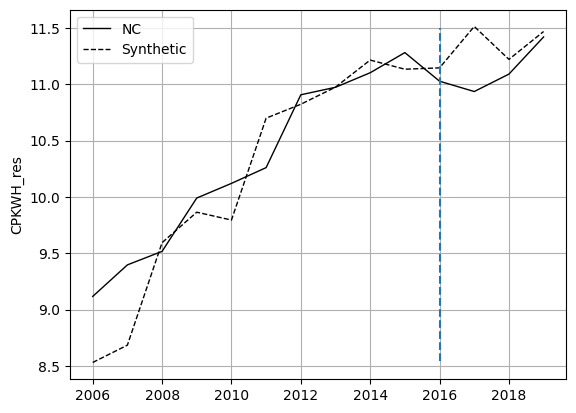

In [69]:
dataprep = Dataprep(
    foo=NC_reg,
    predictors=predictors_cols_res,  
    predictors_op="mean", # sum to minimized SSR
    time_predictors_prior=pre_treatment_years,
    dependent=outcome_col_res,
    unit_variable="STATE",
    time_variable="Year",
    
    treatment_identifier=treatment_id,
    controls_identifier=control_ids,
    
    time_optimize_ssr=(2006,2017) # adding one to include the conclusion of 2016 for optimization
)

# Fit the synthetic control
synth = Synth()
synth.fit(dataprep=dataprep)

# print(synth.weights())
print(synth.summary())

# synth.title("Residential NC IOU")
synth.path_plot(treatment_time=2016, time_period=range(2006, 2020))

#### Commercial

                        V       treated     synthetic   sample mean
log_KWH_com         0.284  8.700000e+00  8.702000e+00  8.624000e+00
log_Cust_com        0.023  1.338800e+01  1.299900e+01  1.223000e+01
effect_cost_coal    0.161  2.041510e+09  2.102202e+09  1.785822e+09
effect_cost_fuel    0.143  3.161024e+06  2.957638e+06  3.987300e+06
effect_cost_ngas    0.000  9.844420e+08  1.415005e+09  8.333198e+08
shore_weather_risk  0.003  1.000000e+00  6.330000e-01  2.140000e-01
log_PCI             0.386 -2.977000e+00 -2.978000e+00 -2.999000e+00


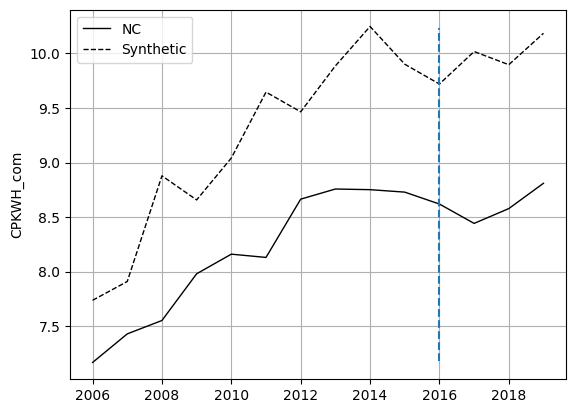

In [70]:
dataprep = Dataprep(
    foo=NC_reg,
    predictors=predictors_cols_com,  
    predictors_op="mean", # sum to minimized SSR
    time_predictors_prior=pre_treatment_years,
    dependent=outcome_col_com,
    unit_variable="STATE",
    time_variable="Year",
    
    treatment_identifier=treatment_id,
    controls_identifier=control_ids,
    
    time_optimize_ssr=(2009,2017) # adding one to include the conclusion of 2016 for optimization
)

# Fit the synthetic control
synth = Synth()
synth.fit(dataprep=dataprep)

# print(synth.weights())
print(synth.summary())

# synth.title("Residential NC IOU")
synth.path_plot(treatment_time=2016, time_period=range(2006, 2020))

#### Industrial

                        V       treated     synthetic   sample mean
log_KWH_indus       0.012  1.225200e+01  1.190200e+01  1.202000e+01
log_Cust_indus      0.227  9.274000e+00  9.278000e+00  8.733000e+00
effect_cost_coal    0.175  2.041510e+09  2.047369e+09  1.785822e+09
effect_cost_fuel    0.093  3.161024e+06  3.112743e+06  3.987300e+06
effect_cost_ngas    0.221  9.844420e+08  1.247427e+09  8.333198e+08
shore_weather_risk  0.096  1.000000e+00  6.870000e-01  2.140000e-01
log_PCI             0.176 -2.977000e+00 -2.975000e+00 -2.999000e+00


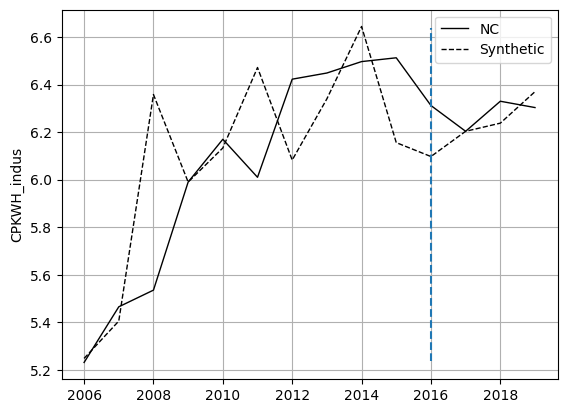

In [71]:
dataprep = Dataprep(
    foo=NC_reg,
    predictors=predictors_cols_indus,  
    predictors_op="mean", # sum to minimized SSR
    time_predictors_prior=pre_treatment_years,
    dependent=outcome_col_indus,
    unit_variable="STATE",
    time_variable="Year",
    
    treatment_identifier=treatment_id,
    controls_identifier=control_ids,
    
    time_optimize_ssr=(2009,2017) # adding one to include the conclusion of 2016 for optimization
)

# Fit the synthetic control
synth = Synth()
synth.fit(dataprep=dataprep)

# print(synth.weights())
print(synth.summary())

# synth.title("Residential NC IOU")
synth.path_plot(treatment_time=2016, time_period=range(2006, 2020))

### IOU Level

In [72]:
# residential
outcome_col_res = "Pr_res" # using pure price var
predictors_cols_res = ["log_kwh_res","log_Cust_res",'effect_cost_coal',
                   'effect_cost_fuel','effect_cost_ngas',"shore_weather_risk",'log_PCI']

#commercial
outcome_col_com = "Pr_com" # using pure price var
predictors_cols_com = ["log_kwh_com","log_Cust_com",'effect_cost_coal',
                   'effect_cost_fuel','effect_cost_ngas',"shore_weather_risk",'log_PCI',]

#industrial
outcome_col_indus = "Pr_indus" # using pure price var
predictors_cols_indus = ["log_kwh_indus","log_Cust_indus",'effect_cost_coal',
                   'effect_cost_fuel','effect_cost_ngas',"shore_weather_risk",'log_PCI']




In [73]:
treatment_id = "NC_Duke Energy Progress (Merged)" # treating only DP from NC

# filtering to remain perfectly collinear entity (.95)
exclusion = ["SC_Duke Energy Progress (Merged)","Virginia Electric Power Co_NC"]

synth_IOU_NC = iou_balanced[~iou_balanced['Combo_Nco_State'].isin(exclusion)]

In [74]:
all_units = synth_IOU_NC["Combo_Nco_State"].unique().tolist() # controlling for the rest
control_ids = [i for i in all_units if i != treatment_id]

#### Residential

In [75]:
dataprep = Dataprep(
    foo=synth_IOU_NC,
    predictors=predictors_cols_res,  
    predictors_op="mean", # sum to minimized SSR
    time_predictors_prior=pre_treatment_years,
    dependent=outcome_col_res,
    unit_variable="Combo_Nco_State",
    time_variable="Year",
    
    treatment_identifier=treatment_id,
    controls_identifier=control_ids,
    
    time_optimize_ssr=(2008,2017) # adding one to include the conclusion of 2016 for optimization
)

                        V   treated  synthetic  sample mean
log_kwh_res         0.078    15.120     13.126        9.618
log_Cust_res        0.000    14.806     12.903        9.677
effect_cost_coal    0.183  2041.510   2031.031     1892.205
effect_cost_fuel    0.045     3.161      3.798        4.339
effect_cost_ngas    0.397   984.442   1024.784      680.453
shore_weather_risk  0.008     1.000      0.582        0.104
log_PCI             0.290    -2.977     -2.975       -2.998


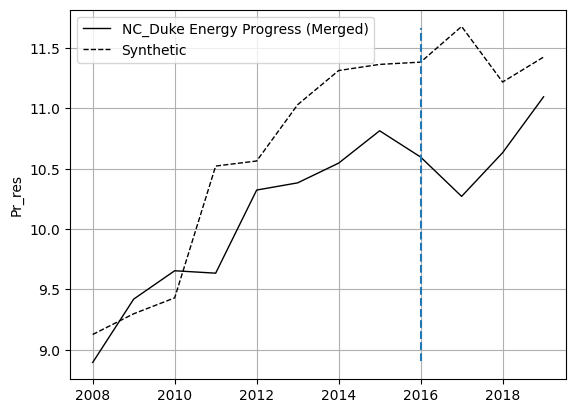

In [76]:
# Fit the synthetic control
synth = Synth()
synth.fit(dataprep=dataprep)

# print(synth.weights())
print(synth.summary())

# synth.title("Residential NC IOU")
synth.path_plot(treatment_time=2016, time_period=range(2008, 2020))

#### Commercial

                        V   treated  synthetic  sample mean
log_kwh_com         0.205    15.323     14.137        9.426
log_Cust_com        0.157    13.024     11.727        7.773
effect_cost_coal    0.140  2041.510   1987.226     1892.205
effect_cost_fuel    0.128     3.161      3.686        4.339
effect_cost_ngas    0.149   984.442   1236.448      680.453
shore_weather_risk  0.025     1.000      0.683        0.104
log_PCI             0.197    -2.977     -2.968       -2.998


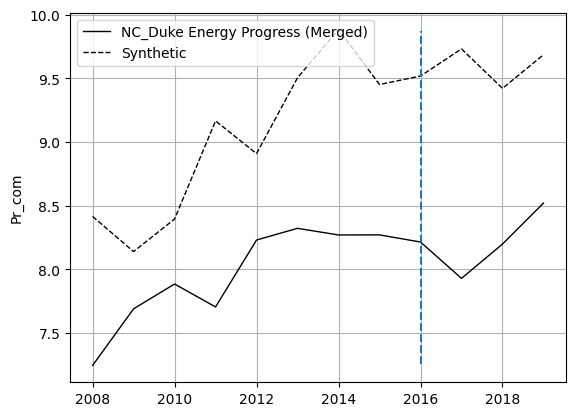

In [77]:
dataprep = Dataprep(
    foo=synth_IOU_NC,
    predictors=predictors_cols_com,  
    predictors_op="mean", # sum to minimized SSR
    time_predictors_prior=pre_treatment_years,
    dependent=outcome_col_com,
    unit_variable="Combo_Nco_State",
    time_variable="Year",
    
    treatment_identifier=treatment_id,
    controls_identifier=control_ids,
    
    time_optimize_ssr=(2008,2017) # adding one to include the conclusion of 2016 for optimization
)

# Fit the synthetic control
synth = Synth()
synth.fit(dataprep=dataprep)


print(synth.summary())

synth.path_plot(treatment_time=2016, time_period=range(2008, 2020))

#### Industrial

                        V   treated  synthetic  sample mean
log_kwh_indus       0.253    15.032     12.163        9.471
log_Cust_indus      0.001     9.097      5.390        3.204
effect_cost_coal    0.101  2041.510   1881.381     1892.205
effect_cost_fuel    0.142     3.161      3.473        4.339
effect_cost_ngas    0.348   984.442   1118.432      680.453
shore_weather_risk  0.155     1.000      0.918        0.104
log_PCI             0.000    -2.977     -3.093       -2.998


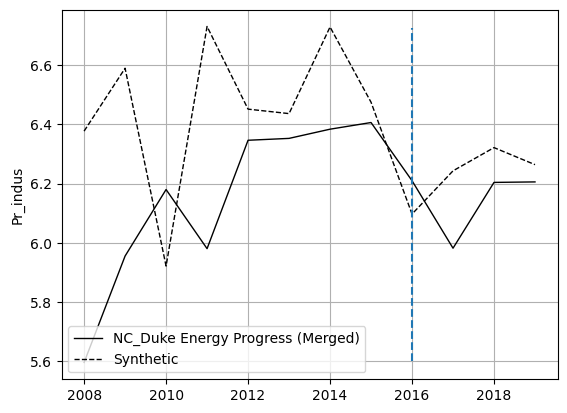

In [78]:
dataprep = Dataprep(
    foo=synth_IOU_NC,
    predictors=predictors_cols_indus,  
    predictors_op="mean", # sum to minimized SSR
    time_predictors_prior=pre_treatment_years,
    dependent=outcome_col_indus,
    unit_variable="Combo_Nco_State",
    time_variable="Year",
    
    treatment_identifier=treatment_id,
    controls_identifier=control_ids,
    
    time_optimize_ssr=(2008,2017) # adding one to include the conclusion of 2016 for optimization
)

# Fit the synthetic control
synth = Synth()
synth.fit(dataprep=dataprep)


print(synth.summary())

synth.path_plot(treatment_time=2016, time_period=range(2008, 2020))

## South Carolina

### State Level

In [79]:
SC_reg = SC_reg.reset_index()

In [80]:
all_units = SC_reg["STATE"].unique().tolist() # controlling for the rest
treatment_id = "SC"
control_ids = [i for i in all_units if i != treatment_id]

In [81]:
# residential
outcome_col_res = "CPKWH_res" # using pure price var
predictors_cols_res = ["log_KWH_res","log_Cust_Res",'effect_cost_coal',
                   'effect_cost_fuel','effect_cost_ngas',"shore_weather_risk",'log_PCI']

#commercial
outcome_col_com = "CPKWH_com" # using pure price var
predictors_cols_com = ["log_KWH_com","log_Cust_com",'effect_cost_coal',
                   'effect_cost_fuel','effect_cost_ngas',"shore_weather_risk",'log_PCI',]

#industrial
outcome_col_indus = "CPKWH_indus" # using pure price var
predictors_cols_indus = ["log_KWH_indus","log_Cust_indus",'effect_cost_coal',
                   'effect_cost_fuel','effect_cost_ngas',"shore_weather_risk",'log_PCI']

#### Residential

                        V       treated     synthetic   sample mean
log_KWH_res         0.056  7.077000e+00  7.068000e+00  6.868000e+00
log_Cust_Res        0.000  1.456500e+01  1.435900e+01  1.406600e+01
effect_cost_coal    0.150  1.132102e+09  1.197101e+09  1.785822e+09
effect_cost_fuel    0.311  2.113863e+06  1.980266e+06  3.987300e+06
effect_cost_ngas    0.024  7.170349e+08  1.819874e+09  8.333198e+08
shore_weather_risk  0.271  1.000000e+00  9.410000e-01  2.140000e-01
log_PCI             0.189 -3.175000e+00 -3.176000e+00 -2.999000e+00


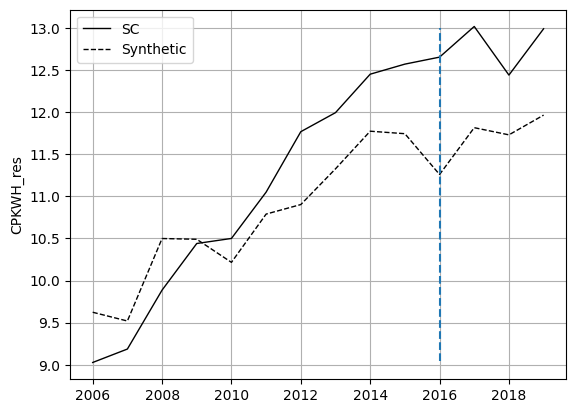

In [82]:
dataprep = Dataprep(
    foo=SC_reg,
    predictors=predictors_cols_res,  
    predictors_op="mean", # sum to minimized SSR
    time_predictors_prior=pre_treatment_years,
    dependent=outcome_col_res,
    unit_variable="STATE",
    time_variable="Year",
    
    treatment_identifier=treatment_id,
    controls_identifier=control_ids,
    
    time_optimize_ssr=(2006,2017) # adding one to include the conclusion of 2016 for optimization
)

synth = Synth()
synth.fit(dataprep=dataprep)

# print(synth.weights()) # Useful for additional information, if needed to identify weights on each control
print(synth.summary())

synth.path_plot(treatment_time=2016, time_period=range(2006, 2020))

#### Commercial

                        V       treated     synthetic   sample mean
log_KWH_com         0.000  8.560000e+00  8.633000e+00  8.624000e+00
log_Cust_com        0.178  1.275200e+01  1.266500e+01  1.223000e+01
effect_cost_coal    0.016  1.132102e+09  1.778373e+09  1.785822e+09
effect_cost_fuel    0.105  2.113863e+06  3.486309e+06  3.987300e+06
effect_cost_ngas    0.553  7.170349e+08  9.486169e+08  8.333198e+08
shore_weather_risk  0.121  1.000000e+00  4.960000e-01  2.140000e-01
log_PCI             0.026 -3.175000e+00 -3.049000e+00 -2.999000e+00


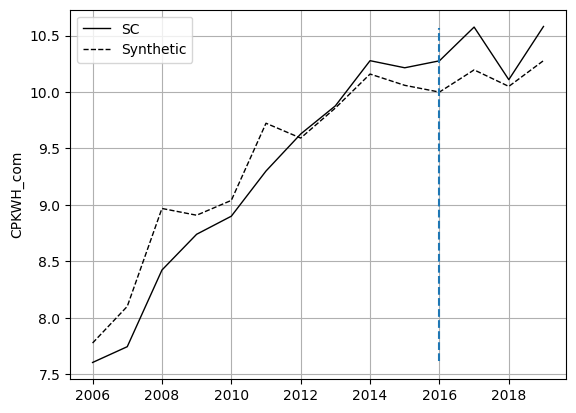

In [83]:
dataprep = Dataprep(
    foo=SC_reg,
    predictors=predictors_cols_com,  
    predictors_op="mean", # sum to minimized SSR
    time_predictors_prior=pre_treatment_years,
    dependent=outcome_col_com,
    unit_variable="STATE",
    time_variable="Year",
    
    treatment_identifier=treatment_id,
    controls_identifier=control_ids,
    
    time_optimize_ssr=(2006,2017) # adding one to include the conclusion of 2016 for optimization
)

# Fit the synthetic control
synth = Synth()
synth.fit(dataprep=dataprep)

# print(synth.weights()) # Useful for additional information, if needed to identify weights on each control
print(synth.summary())

synth.path_plot(treatment_time=2016, time_period=range(2006, 2020))

#### Industrial

                        V       treated     synthetic   sample mean
log_KWH_indus       0.149  1.316900e+01  1.297400e+01  1.202000e+01
log_Cust_indus      0.168  8.407000e+00  8.213000e+00  8.733000e+00
effect_cost_coal    0.138  1.132102e+09  1.308330e+09  1.785822e+09
effect_cost_fuel    0.188  2.113863e+06  2.344468e+06  3.987300e+06
effect_cost_ngas    0.176  7.170349e+08  8.812601e+08  8.333198e+08
shore_weather_risk  0.000  1.000000e+00  3.760000e-01  2.140000e-01
log_PCI             0.181 -3.175000e+00 -3.153000e+00 -2.999000e+00


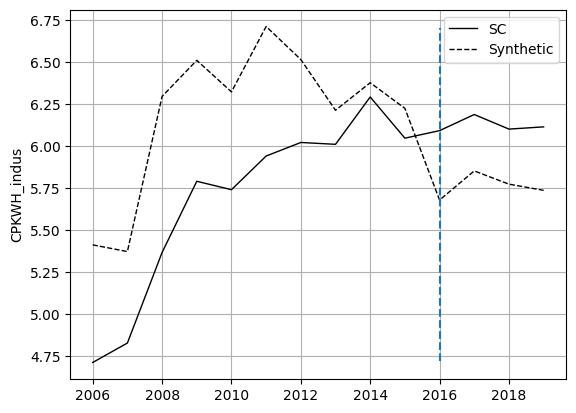

In [84]:
dataprep = Dataprep(
    foo=SC_reg,
    predictors=predictors_cols_indus,  
    predictors_op="mean", # sum to minimized SSR
    time_predictors_prior=pre_treatment_years,
    dependent=outcome_col_indus,
    unit_variable="STATE",
    time_variable="Year",
    
    treatment_identifier=treatment_id,
    controls_identifier=control_ids,
    
    time_optimize_ssr=(2006,2017) # adding one to include the conclusion of 2016 for optimization
)

# Fit the synthetic control
synth = Synth()
synth.fit(dataprep=dataprep)

# print(synth.weights()) # Useful for additional information, if needed to identify weights on each control
print(synth.summary())

synth.path_plot(treatment_time=2016, time_period=range(2006, 2020))

### IOU Level

In [85]:
# filtering to remain perfectly collinear entity (.95)
exclusion = ["NC_Duke Energy Progress (Merged)","Virginia Electric Power Co_NC"]

synth_IOU_SC = iou_balanced[~iou_balanced['Combo_Nco_State'].isin(exclusion)]

In [86]:
all_units = synth_IOU_SC["Combo_Nco_State"].unique().tolist() # controlling for the rest
treatment_id_SC = "SC_Duke Energy Progress (Merged)" # treating only DP from SC
control_ids_SC = [i for i in all_units if i != treatment_id_SC]

In [87]:
# residential
outcome_col_res = "Pr_res" # using pure price var
predictors_cols_res = ["log_kwh_res","log_Cust_res",'effect_cost_coal',
                   'effect_cost_fuel','effect_cost_ngas',"shore_weather_risk",'log_PCI']

#commercial
outcome_col_com = "Pr_com" # using pure price var
predictors_cols_com = ["log_kwh_com","log_Cust_com",'effect_cost_coal',
                   'effect_cost_fuel','effect_cost_ngas',"shore_weather_risk",'log_PCI',]

#industrial
outcome_col_indus = "Pr_indus" # using pure price var
predictors_cols_indus = ["log_kwh_indus","log_Cust_indus",'effect_cost_coal',
                   'effect_cost_fuel','effect_cost_ngas',"shore_weather_risk",'log_PCI']


#### Residential

                        V   treated  synthetic  sample mean
log_kwh_res         0.281    13.726     12.932        9.618
log_Cust_res        0.111    13.293     12.784        9.677
effect_cost_coal    0.328  1132.102   1138.562     1892.205
effect_cost_fuel    0.081     2.114      2.576        4.339
effect_cost_ngas    0.061   717.035   1148.344      680.453
shore_weather_risk  0.011     1.000      0.487        0.104
log_PCI             0.128    -3.175     -3.164       -2.998


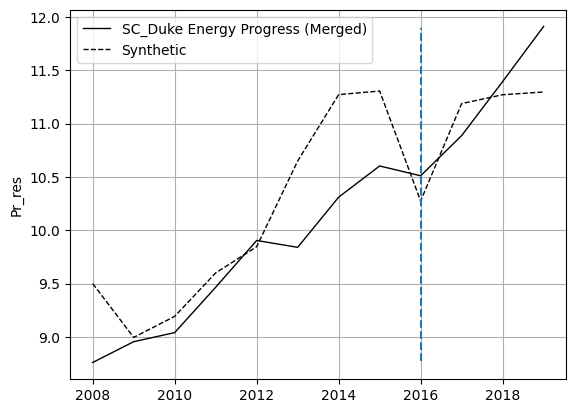

In [88]:
dataprep = Dataprep(
    foo=synth_IOU_SC,
    predictors=predictors_cols_res,  
    predictors_op="mean", # sum to minimized SSR
    time_predictors_prior=pre_treatment_years,
    dependent=outcome_col_res,
    unit_variable="Combo_Nco_State",
    time_variable="Year",
    
    treatment_identifier=treatment_id_SC,
    controls_identifier=control_ids_SC,
    
    time_optimize_ssr=(2008,2017) # adding one to include the conclusion of 2016 for optimization
)

# Fit the synthetic control
synth = Synth()
synth.fit(dataprep=dataprep)

# print(synth.weights())
print(synth.summary())

# synth.title("Residential NC IOU")
synth.path_plot(treatment_time=2016, time_period=range(2008, 2020))

#### Commercial

                        V   treated  synthetic  sample mean
log_kwh_com         0.324    13.730     13.380        9.426
log_Cust_com        0.375    11.693     11.307        7.773
effect_cost_coal    0.170  1132.102   1241.981     1892.205
effect_cost_fuel    0.105     2.114      1.820        4.339
effect_cost_ngas    0.026   717.035    827.254      680.453
shore_weather_risk  0.000     1.000      0.197        0.104
log_PCI             0.000    -3.175     -2.975       -2.998


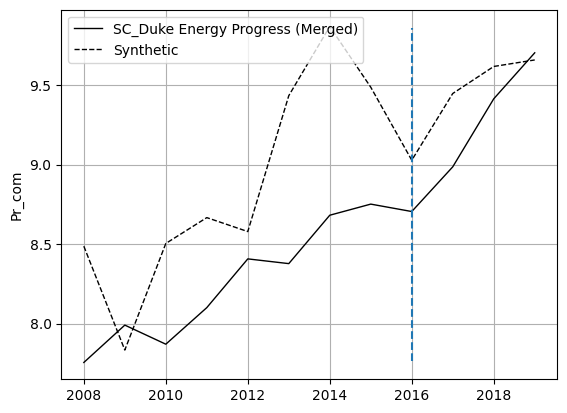

In [89]:
dataprep = Dataprep(
    foo=synth_IOU_SC,
    predictors=predictors_cols_com,  
    predictors_op="mean", # sum to minimized SSR
    time_predictors_prior=pre_treatment_years,
    dependent=outcome_col_com,
    unit_variable="Combo_Nco_State",
    time_variable="Year",
    
    treatment_identifier=treatment_id_SC,
    controls_identifier=control_ids_SC,
    
    time_optimize_ssr=(2008,2017) # adding one to include the conclusion of 2016 for optimization
)

# Fit the synthetic control
synth = Synth()
synth.fit(dataprep=dataprep)

# print(synth.weights())
print(synth.summary())

# synth.title("Residential NC IOU")
synth.path_plot(treatment_time=2016, time_period=range(2008, 2020))

#### Industrial

                        V   treated  synthetic  sample mean
log_kwh_indus       0.263    14.494     13.454        9.471
log_Cust_indus      0.352     7.787      6.880        3.204
effect_cost_coal    0.006  1132.102   2108.742     1892.205
effect_cost_fuel    0.040     2.114      3.775        4.339
effect_cost_ngas    0.312   717.035    855.755      680.453
shore_weather_risk  0.014     1.000      0.400        0.104
log_PCI             0.012    -3.175     -3.027       -2.998


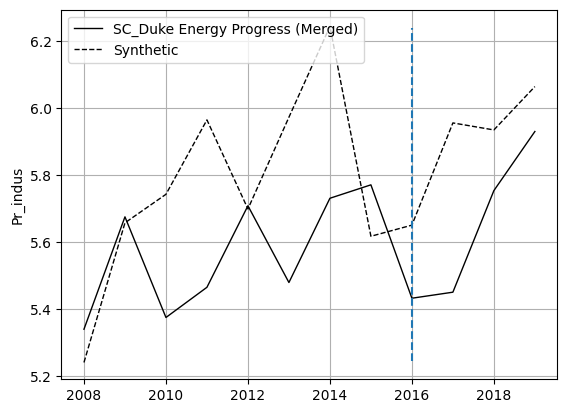

In [90]:
dataprep = Dataprep(
    foo=synth_IOU_SC,
    predictors=predictors_cols_indus,  
    predictors_op="mean", # sum to minimized SSR
    time_predictors_prior=pre_treatment_years,
    dependent=outcome_col_indus,
    unit_variable="Combo_Nco_State",
    time_variable="Year",
    
    treatment_identifier=treatment_id_SC,
    controls_identifier=control_ids_SC,
    
    time_optimize_ssr=(2008,2017) # adding one to include the conclusion of 2016 for optimization
)

# Fit the synthetic control
synth = Synth()
synth.fit(dataprep=dataprep)

# print(synth.weights())
print(synth.summary())

# synth.title("Residential NC IOU")
synth.path_plot(treatment_time=2016, time_period=range(2008, 2020))

# Push to GIT

In [92]:
!git init
!git config --global user.name "Scott (Sarthak) V."
!git config --global user.email "vale.scott00@gmail.com"

!git remote add origin https://github.com/scottSart/DP_Cornerstone.git
!git add "Regression Analysis.ipynb"
!git commit -m "Initial commit: Research code push"
!git branch -M main
!git push -u origin main


!git remote add origin https://github.com/scottSart/DP_Cornerstone.git

!git init

Reinitialized existing Git repository in C:/Users/Sarth/OneDrive/Merger Analysis of Duke Energy and Progress Energy/Git testing/.git/


error: remote origin already exists.


[main 8976de3] Initial commit: Research code push
 1 file changed, 50 insertions(+), 4 deletions(-)


To https://github.com/sarthakvij17/DP_Cornerstone.git
 ! [rejected]        main -> main (fetch first)
error: failed to push some refs to 'https://github.com/sarthakvij17/DP_Cornerstone.git'
hint: Updates were rejected because the remote contains work that you do not
hint: have locally. This is usually caused by another repository pushing to
hint: the same ref. If you want to integrate the remote changes, use
hint: 'git pull' before pushing again.
hint: See the 'Note about fast-forwards' in 'git push --help' for details.
error: remote origin already exists.


Reinitialized existing Git repository in C:/Users/Sarth/OneDrive/Merger Analysis of Duke Energy and Progress Energy/Git testing/.git/
